# Customer Segmentation: Clustering

**In this project I will be using KNN and SVC to perform unsupervised clustering on a shop database.**

Audience segmentation has many benefits to a company's product pricing and marketing strategies. Companies can look to bundle products or services together for needs that are reflected in specific segments. They can equip their sales and marketing teams with a better understanding of customers and their preferences, leading to better conversion rates and personalised advertising.

## Imports

**Library Imports**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.svm import SVC
from yellowbrick.cluster import KElbowVisualizer
import warnings
warnings.filterwarnings('ignore')

**Data Imports**

In [4]:
df = pd.read_csv('raw_data/marketing_campaign.csv', sep='\t')

## Data Cleaning

The first thing I'm going to do is a make a copy of the original dataset and call it data.

Then I will take a look for any missing values, the number of observations there are and if we have any duplicates.

In [5]:
data = df.copy()

In [6]:
data.head(5)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [7]:
no_observations = len(data)
no_observations

2240

In [8]:
data.isnull().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

We have a relatively clean dataset with only 24 missing values in the Income column, out of a dataset of 2240 observations. 

As the number is so small I will just remove the rows as there is no need to impute them as the overall dataset will remain large enough to continue.

In [9]:
data.dropna(inplace=True)

In [10]:
data.duplicated().sum()

0

**We can see that there are no duplicated values in the dataset, we are good to proceed to the next step and dive deeper into the data with some EDA**

## Exploratory Data Analysis

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2216 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2216 non-null   int64  
 1   Year_Birth           2216 non-null   int64  
 2   Education            2216 non-null   object 
 3   Marital_Status       2216 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2216 non-null   int64  
 6   Teenhome             2216 non-null   int64  
 7   Dt_Customer          2216 non-null   object 
 8   Recency              2216 non-null   int64  
 9   MntWines             2216 non-null   int64  
 10  MntFruits            2216 non-null   int64  
 11  MntMeatProducts      2216 non-null   int64  
 12  MntFishProducts      2216 non-null   int64  
 13  MntSweetProducts     2216 non-null   int64  
 14  MntGoldProds         2216 non-null   int64  
 15  NumDealsPurchases    2216 non-null   i

**We can see that there are 29 columns/features that we are able to use to segment our audience.**
 - 3 object features
 - 1 float feature
 - 25 integer features

Let's take a deeper look and see what we can find out about our features, there might be some additional ones we can create through feature engineering or ones that aren't important to our task.

In [12]:
data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'])

In [13]:
data['Dt_Customer'].max()

Timestamp('2014-12-06 00:00:00')

In [14]:
data['Dt_Customer'].min()

Timestamp('2012-01-08 00:00:00')

I am going to create a new feature that will take the Dt_Customer time stamp and find the distance from the most recent timestamp,
as this will provide us with a more relevant and contextualised feature as opposed to an arbitrary date

In [15]:
data['Customer_For'] = data['Dt_Customer'].apply(lambda x: data['Dt_Customer'].max() - x)

In [16]:
data.head(1)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Customer_For
0,5524,1957,Graduation,Single,58138.0,0,0,2012-04-09,58,635,...,0,0,0,0,0,0,3,11,1,971 days


**I am going to do the same for Year_Birth by creating a new feature called 'Age'**

In [17]:
data['Age'] = 2024 - data['Year_Birth']

In [18]:
data.head(1)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Customer_For,Age
0,5524,1957,Graduation,Single,58138.0,0,0,2012-04-09,58,635,...,0,0,0,0,0,3,11,1,971 days,67


In [19]:
data.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response',
       'Customer_For', 'Age'],
      dtype='object')

**We can segment our features!**

Having taken a look at the full list of our features we can see that there are 4 distinct groups we can segment our features into.
 - Customer information
 - Products
 - Place
 - Promotion

In [20]:
customer_info = ['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 'Recency', 'Complain', 'Customer_For', 'Age']

In [21]:
products = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']

In [22]:
place = ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']

In [23]:
promotion = ['NumDealsPurchases', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']

### Customer Info

**I will be taking a closer look at the features within the customer info list**

1. What are the categorical features? What is the spread of observations among them?

2. What are the continuous features? What is the distribution? Are there any outliers?

3. What are the binary features? What are the differences in observations between the two?

In [24]:
data[customer_info].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2216 entries, 0 to 2239
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype          
---  ------          --------------  -----          
 0   ID              2216 non-null   int64          
 1   Year_Birth      2216 non-null   int64          
 2   Education       2216 non-null   object         
 3   Marital_Status  2216 non-null   object         
 4   Income          2216 non-null   float64        
 5   Kidhome         2216 non-null   int64          
 6   Teenhome        2216 non-null   int64          
 7   Dt_Customer     2216 non-null   datetime64[ns] 
 8   Recency         2216 non-null   int64          
 9   Complain        2216 non-null   int64          
 10  Customer_For    2216 non-null   timedelta64[ns]
 11  Age             2216 non-null   int64          
dtypes: datetime64[ns](1), float64(1), int64(7), object(2), timedelta64[ns](1)
memory usage: 225.1+ KB


**Categorical Features**

In [25]:
data['Education'].value_counts()

Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: Education, dtype: int64

In [26]:
(data['Education'].value_counts() / 2212) * 100

Graduation    50.452080
PhD           21.745027
Master        16.500904
2n Cycle       9.041591
Basic          2.441230
Name: Education, dtype: float64

From the above we can see that over 50% of the audience has graduated with 22% reaching PhD and 17% Masters degrees. This seems to be a very educated audience with nearly 40% of people having completed a post graduate degree.

In [27]:
data['Marital_Status'].value_counts()

Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64

In [28]:
(data['Marital_Status'].value_counts() / 2212) * 100

Married     38.743219
Together    25.904159
Single      21.292948
Divorced    10.488246
Widow        3.435805
Alone        0.135624
Absurd       0.090416
YOLO         0.090416
Name: Marital_Status, dtype: float64

Nearly 40% of the dataset is made up of Married couples with 26% in relationships and 21% are single, with some labelling themselves as Alone, Absurd and Yolo

In [29]:
data['Kidhome'].value_counts()

0    1283
1     887
2      46
Name: Kidhome, dtype: int64

In [30]:
(data['Kidhome'].value_counts() / 2212) * 100

0    58.001808
1    40.099458
2     2.079566
Name: Kidhome, dtype: float64

Nearly 60% of the audience do not have any kids at home, while 40% have 1 and 2% have 2

In [31]:
data['Teenhome'].value_counts()

0    1147
1    1018
2      51
Name: Teenhome, dtype: int64

In [32]:
(data['Teenhome'].value_counts() / 2212) * 100

0    51.853526
1    46.021700
2     2.305606
Name: Teenhome, dtype: float64

The make up is very similar to kids at home, with over 50% having none, 46% having 1 and 2% having 2

**Continuous Features**

<AxesSubplot:xlabel='Income', ylabel='Count'>

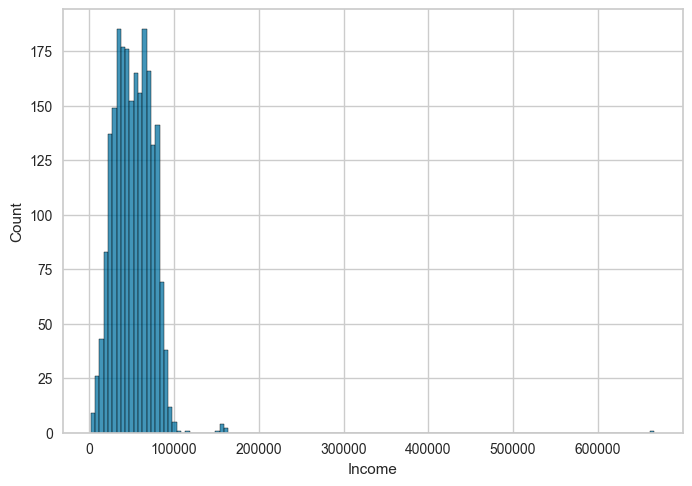

In [33]:
sns.histplot(data=data['Income'])

<AxesSubplot:xlabel='Age', ylabel='Count'>

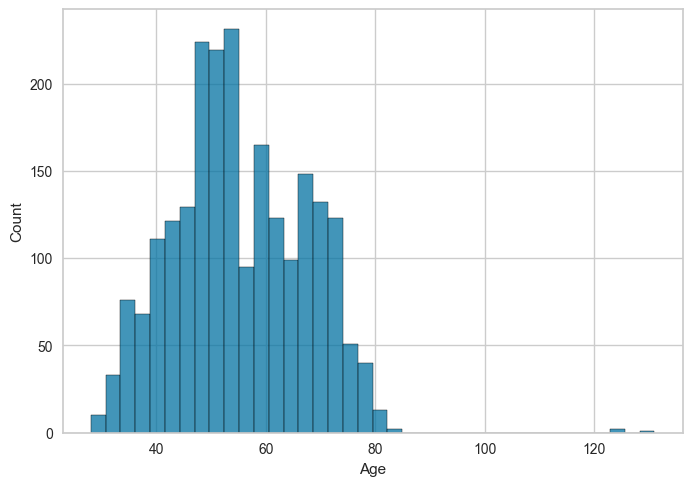

In [34]:
sns.histplot(data=data['Age'])

**The recency feature is the number of days since a customer's last purchase**

<AxesSubplot:xlabel='Recency', ylabel='Count'>

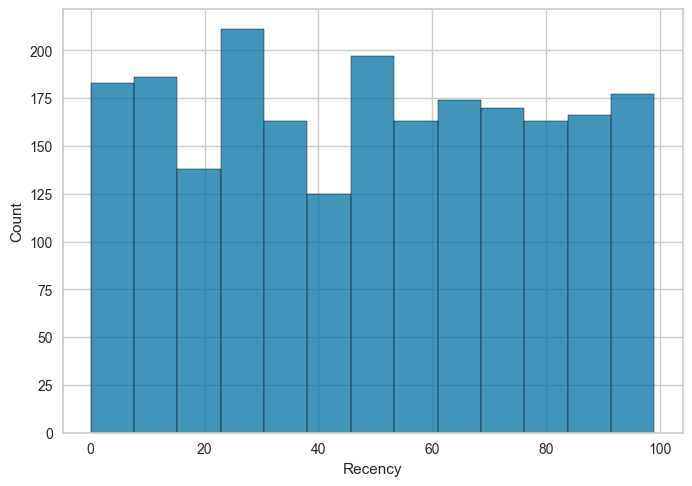

In [35]:
sns.histplot(data=data['Recency'])

### Products

**Once again I will be taking a closer look at the features within the products list**

1. What are the categorical features? What is the spread of observations among them?

2. What are the continuous features? What is the distribution? Are there any outliers?

3. What are the binary features? What are the differences in observations between the two?

In [36]:
data[products].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2216 entries, 0 to 2239
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   MntWines          2216 non-null   int64
 1   MntFruits         2216 non-null   int64
 2   MntMeatProducts   2216 non-null   int64
 3   MntFishProducts   2216 non-null   int64
 4   MntSweetProducts  2216 non-null   int64
 5   MntGoldProds      2216 non-null   int64
dtypes: int64(6)
memory usage: 121.2 KB


<AxesSubplot:xlabel='MntGoldProds', ylabel='Count'>

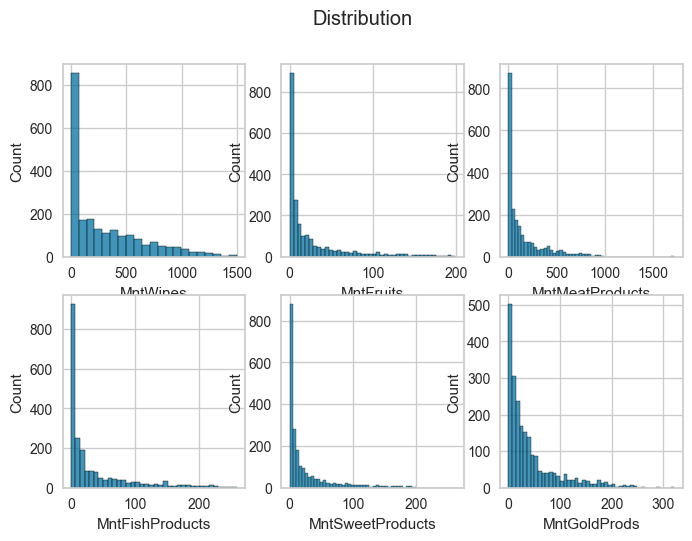

In [37]:
fig, axs = plt.subplots(2,3)
fig.suptitle('Distribution')

sns.histplot(data=data['MntWines'], ax=axs[0,0])
sns.histplot(data=data['MntFruits'], ax=axs[0,1])
sns.histplot(data=data['MntMeatProducts'], ax=axs[0,2])
sns.histplot(data=data['MntFishProducts'], ax=axs[1,0])
sns.histplot(data=data['MntSweetProducts'], ax=axs[1,1])
sns.histplot(data=data['MntGoldProds'], ax=axs[1,2])

In [38]:
data[products].describe()

,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253
std,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000
50%,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000
75%,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000
max,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000


### Place

**Once again I will be taking a closer look at the features within the place list**

1. What are the categorical features? What is the spread of observations among them?

2. What are the continuous features? What is the distribution? Are there any outliers?

3. What are the binary features? What are the differences in observations between the two?

In [39]:
data[place].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2216 entries, 0 to 2239
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   NumWebPurchases      2216 non-null   int64
 1   NumCatalogPurchases  2216 non-null   int64
 2   NumStorePurchases    2216 non-null   int64
 3   NumWebVisitsMonth    2216 non-null   int64
dtypes: int64(4)
memory usage: 86.6 KB


<AxesSubplot:xlabel='NumWebVisitsMonth', ylabel='Count'>

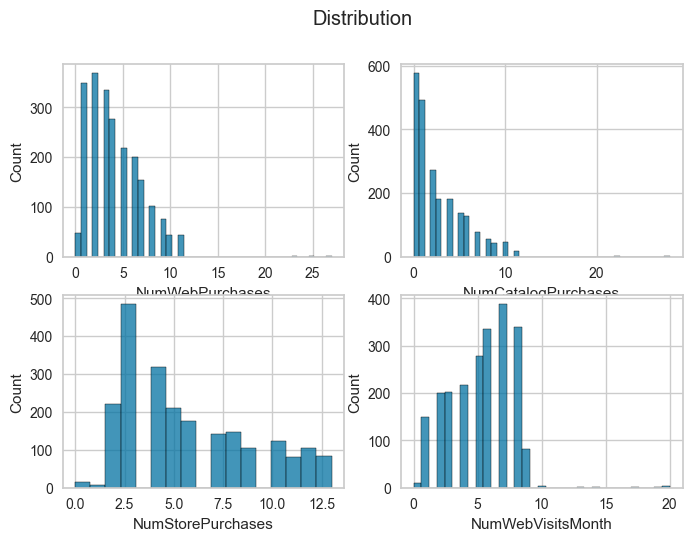

In [40]:
fig, axs = plt.subplots(2,2)
fig.suptitle('Distribution')

sns.histplot(data=data['NumWebPurchases'], ax=axs[0,0])
sns.histplot(data=data['NumCatalogPurchases'], ax=axs[0,1])
sns.histplot(data=data['NumStorePurchases'], ax=axs[1,0])
sns.histplot(data=data['NumWebVisitsMonth'], ax=axs[1,1])

In [41]:
data[place].describe()

,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth
count,2216.000000,2216.000000,2216.000000,2216.000000
mean,4.085289,2.671029,5.800993,5.319043
std,2.740951,2.926734,3.250785,2.425359
min,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,3.000000,3.000000
50%,4.000000,2.000000,5.000000,6.000000
75%,6.000000,4.000000,8.000000,7.000000
max,27.000000,28.000000,13.000000,20.000000


### Promotion

**Finally I will be taking a closer look at the features within the promotion list**

1. What are the categorical features? What is the spread of observations among them?

2. What are the continuous features? What is the distribution? Are there any outliers?

3. What are the binary features? What are the differences in observations between the two?

In [42]:
data[promotion].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2216 entries, 0 to 2239
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   NumDealsPurchases  2216 non-null   int64
 1   AcceptedCmp1       2216 non-null   int64
 2   AcceptedCmp2       2216 non-null   int64
 3   AcceptedCmp3       2216 non-null   int64
 4   AcceptedCmp4       2216 non-null   int64
 5   AcceptedCmp5       2216 non-null   int64
 6   Response           2216 non-null   int64
dtypes: int64(7)
memory usage: 138.5 KB


<AxesSubplot:xlabel='NumDealsPurchases', ylabel='Count'>

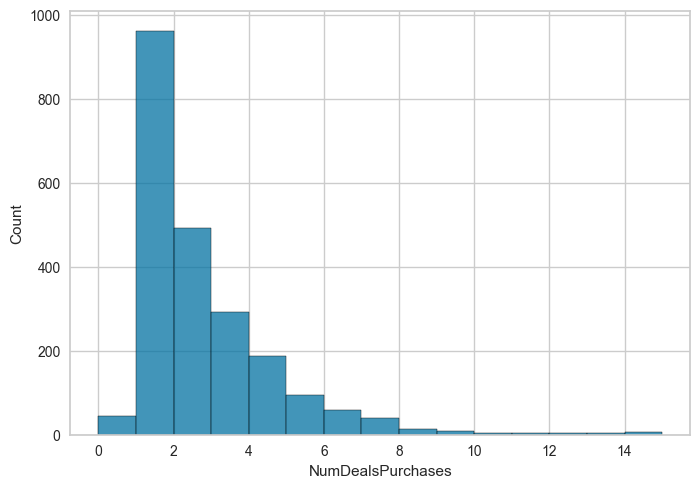

In [43]:
sns.histplot(data=data['NumDealsPurchases'], bins=15)

In [44]:
data['NumDealsPurchases'].describe()

count    2216.000000
mean        2.323556
std         1.923716
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        15.000000
Name: NumDealsPurchases, dtype: float64

In [45]:
data['AcceptedCmp1'].value_counts()

0    2074
1     142
Name: AcceptedCmp1, dtype: int64

In [46]:
data['AcceptedCmp2'].value_counts()

0    2186
1      30
Name: AcceptedCmp2, dtype: int64

In [47]:
data['AcceptedCmp3'].value_counts()

0    2053
1     163
Name: AcceptedCmp3, dtype: int64

In [48]:
data['AcceptedCmp4'].value_counts()

0    2052
1     164
Name: AcceptedCmp4, dtype: int64

In [49]:
data['AcceptedCmp5'].value_counts()

0    2054
1     162
Name: AcceptedCmp5, dtype: int64

In [50]:
data['Response'].value_counts()

0    1883
1     333
Name: Response, dtype: int64

### Feature Engineering

**Simplify the features in the dataset**

I am going to drop some of the already transformed features (Dt_Customer, Year_Birth). I am also going to group some of the categories in the Customer_info list, and combine some of the product feature lists.

Finally, I think I will change some feature names to improve the legibility of the dataset.

In [51]:
data.drop(columns=['Dt_Customer', 'Year_Birth'], inplace=True)

In [52]:
data['Relationship'] = data['Marital_Status'].replace({'Married':'Partner', 'Together':'Partner', 'Absurd':'Alone', 'Widow':'Alone', 'YOLO':'Alone', 'Divorced':'Alone', 'Single':'Alone'})

In [53]:
data['Children'] = data['Kidhome'] + data['Teenhome']

In [54]:
data['Household'] = data['Relationship'].replace({'Partner':2, 'Alone': 1}) + data['Children']

In [55]:
data['Parent'] = data['Children'].apply(lambda x: 1 if x > 0 else 0)

In [56]:
data['Education'] = data['Education'].replace({'Basic':'Undergraduate', '2n Cycle':'Undergraduate', 'Graduation':'Graduate', 'Master':'Postgraduate', 'PhD':'Postgraduate'})

In [57]:
data['Spent'] = data['MntWines']+ data['MntFruits']+ data['MntMeatProducts']+ data['MntFishProducts']+ data['MntSweetProducts']+ data['MntGoldProds']

In [58]:
data = data.rename(columns={'MntWines':'Wines', 'MntFruits':'Fruits', 'MntMeatProducts':'Meat', 'MntFishProducts':'Fish', 'MntSweetProducts':'Sweets', 'MntGoldProds':'Gold'})

In [59]:
data.drop(columns=['Marital_Status', 'Z_CostContact', 'Z_Revenue', 'ID'], inplace=True)

In [60]:
data.head(5)

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,AcceptedCmp2,Complain,Response,Customer_For,Age,Relationship,Children,Household,Parent,Spent
0,Graduate,58138.0,0,0,58,635,88,546,172,88,...,0,0,1,971 days,67,Alone,0,1,0,1617
1,Graduate,46344.0,1,1,38,11,1,6,2,1,...,0,0,0,125 days,70,Alone,2,3,1,27
2,Graduate,71613.0,0,0,26,426,49,127,111,21,...,0,0,0,472 days,59,Partner,0,2,0,776
3,Graduate,26646.0,1,0,26,11,4,20,10,3,...,0,0,0,65 days,40,Partner,1,3,1,53
4,Postgraduate,58293.0,1,0,94,173,43,118,46,27,...,0,0,0,321 days,43,Partner,1,3,1,422


<AxesSubplot:>

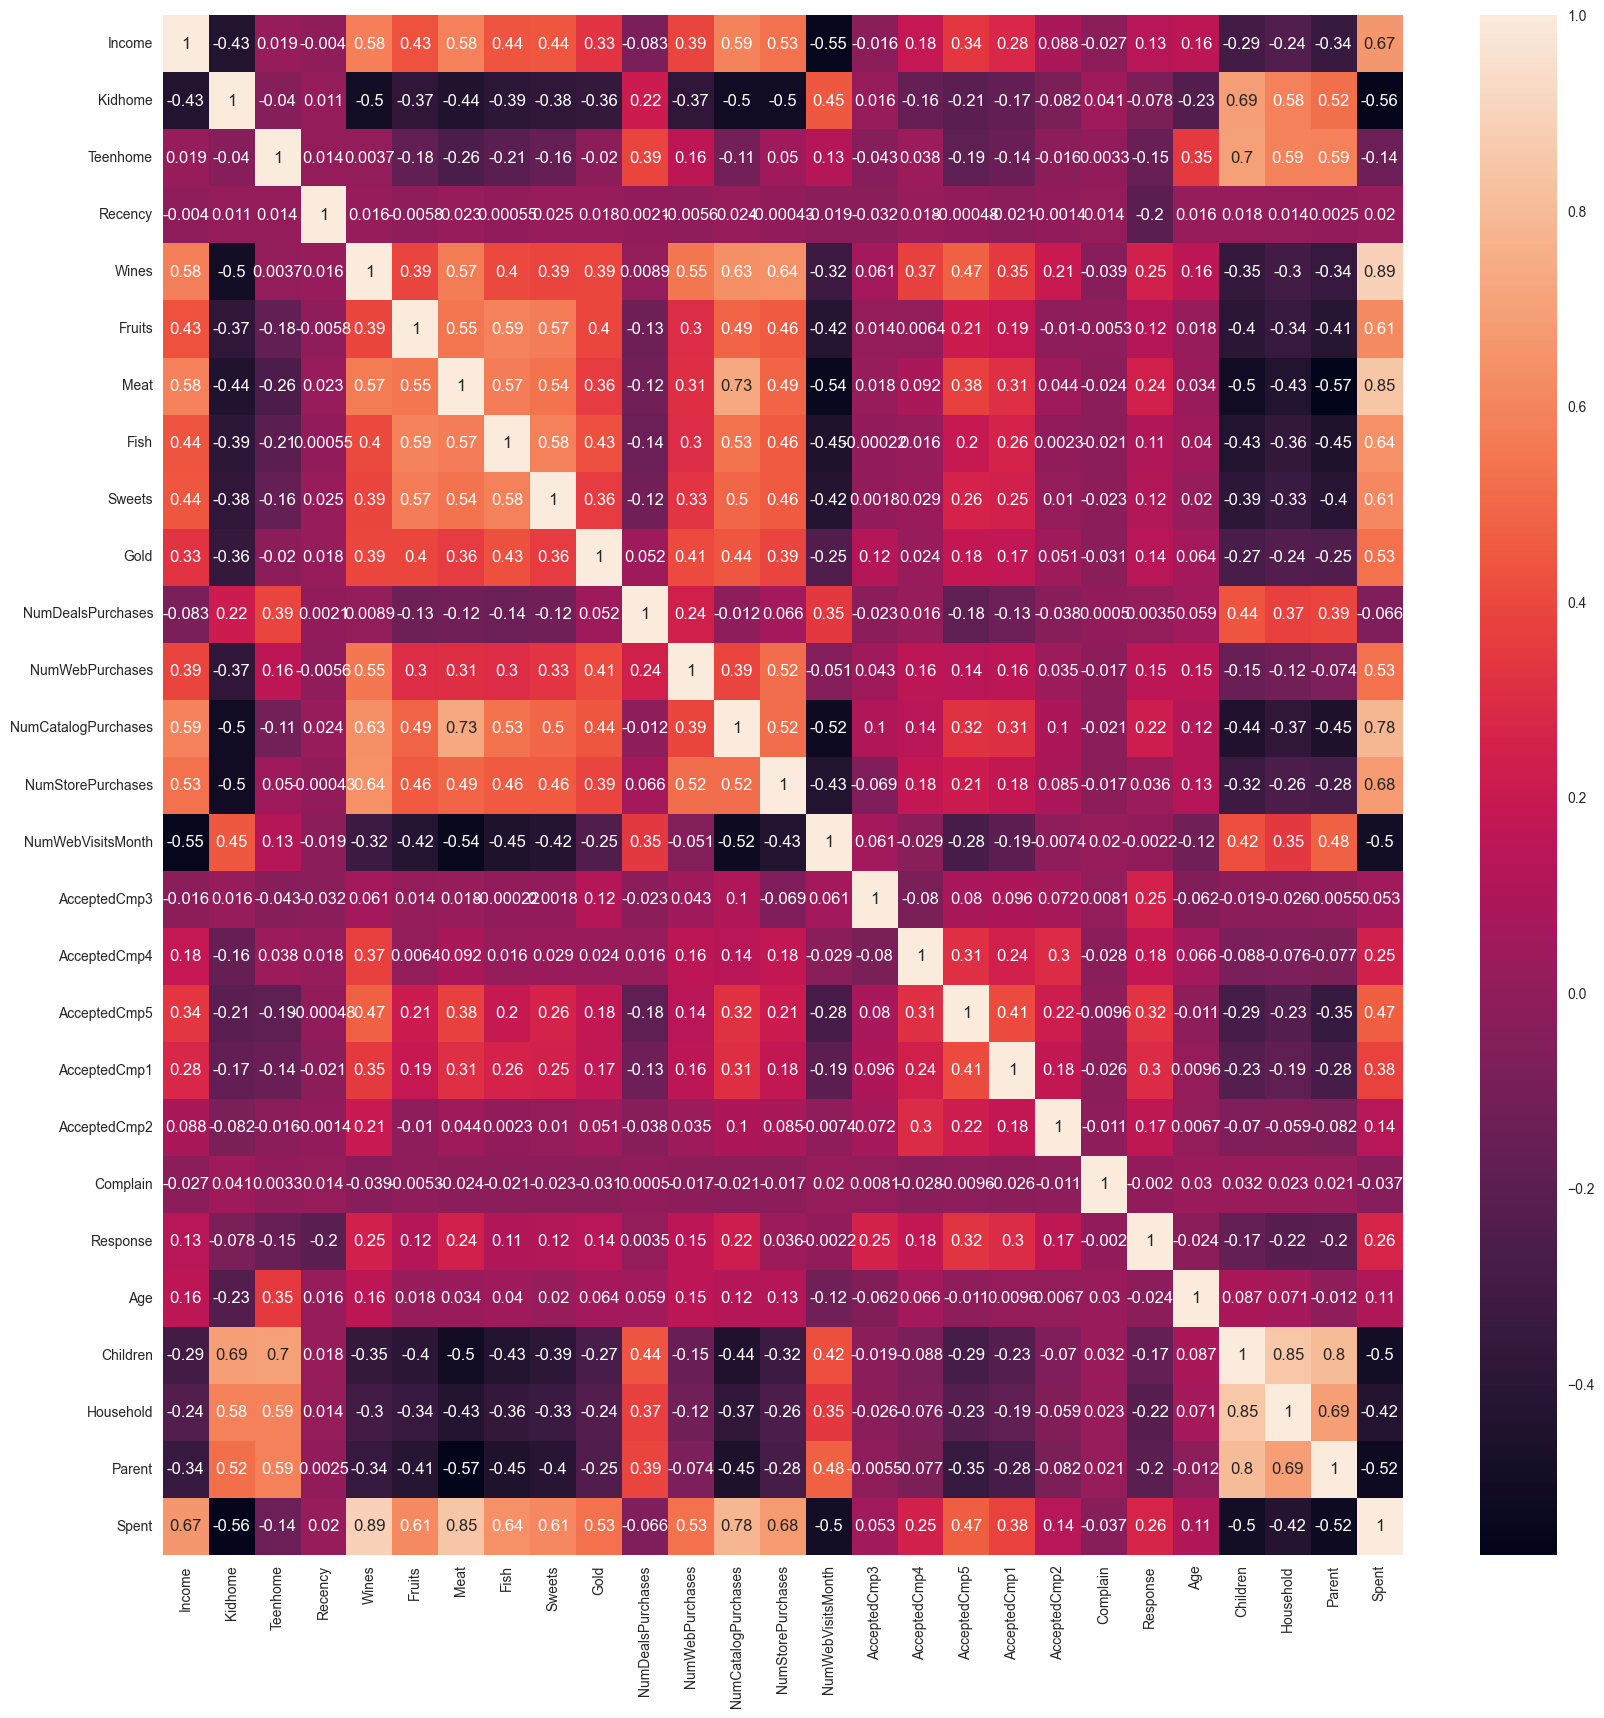

In [61]:
plt.figure(figsize=(20,20))
sns.heatmap(data=data.corr(), annot=True)

## Data Pre-processing

**In this section I will be preprocesing the data in preparation for the clustering**

- I will start with transforming the categorical features into numerical format with either One-Hot-Encoding or Label-Encoding
- I will also work on scaling the continuous data to have everything relative
- The high number of categories will also most likely lead to an even higher number of features, so I will be performing a PCA to reduce the dimensionality of the dataset

In [62]:
object = data.dtypes == 'object'
cat = object[object].index
cat

Index(['Education', 'Relationship'], dtype='object')

Normally I would use One-Hot-Encoding for a task like this, as I don't want to introduce artificial ordinality into the dataset. However for these two features our previous feature engineering reduced the number of categories to two, this allows us to Label Encode both features and not increase dimensionality in the process.

In [63]:
encoder = LabelEncoder()
data[cat] = data[cat].apply(encoder.fit_transform)
data.head(5)

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,AcceptedCmp2,Complain,Response,Customer_For,Age,Relationship,Children,Household,Parent,Spent
0,0,58138.0,0,0,58,635,88,546,172,88,...,0,0,1,971 days,67,0,0,1,0,1617
1,0,46344.0,1,1,38,11,1,6,2,1,...,0,0,0,125 days,70,0,2,3,1,27
2,0,71613.0,0,0,26,426,49,127,111,21,...,0,0,0,472 days,59,1,0,2,0,776
3,0,26646.0,1,0,26,11,4,20,10,3,...,0,0,0,65 days,40,1,1,3,1,53
4,1,58293.0,1,0,94,173,43,118,46,27,...,0,0,0,321 days,43,1,1,3,1,422


In [64]:
data['Customer_For'] = data['Customer_For'].dt.days.astype(int)
data.head(5)

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,AcceptedCmp2,Complain,Response,Customer_For,Age,Relationship,Children,Household,Parent,Spent
0,0,58138.0,0,0,58,635,88,546,172,88,...,0,0,1,971,67,0,0,1,0,1617
1,0,46344.0,1,1,38,11,1,6,2,1,...,0,0,0,125,70,0,2,3,1,27
2,0,71613.0,0,0,26,426,49,127,111,21,...,0,0,0,472,59,1,0,2,0,776
3,0,26646.0,1,0,26,11,4,20,10,3,...,0,0,0,65,40,1,1,3,1,53
4,1,58293.0,1,0,94,173,43,118,46,27,...,0,0,0,321,43,1,1,3,1,422


**All features in the dataset are now numerical!**

In [65]:
# Creating a copy of the original dataset and removing the AcceptedCmp features as well as Complain and Response
dp = data.copy()

dp.drop(columns=['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Complain', 'Response'], inplace=True)

**For scaling the date I will be using the RobustScaler**

The distribution of the features have mostly been skewed so the choice was between the MinMax and the RobustScaler. The presence of outliers in many of the features however let me to use the RobustScaler.

In [66]:
scaler = RobustScaler()
scaler.fit(dp)
scaled_dp = pd.DataFrame(scaler.transform(dp), columns=dp.columns)

In [67]:
scaled_dp.head(5)

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Customer_For,Age,Relationship,Children,Household,Parent,Spent
0,0.0,0.203393,0.0,0.0,0.18,0.957380,2.580645,2.210405,3.404255,2.50000,...,2.00,-0.2,0.25,1.323699,0.722222,-1.0,-1.0,-2.0,-1.0,1.246680
1,0.0,-0.151645,1.0,1.0,-0.22,-0.339917,-0.225806,-0.286705,-0.212766,-0.21875,...,-0.25,-0.6,-0.25,-1.121387,0.888889,-1.0,1.0,0.0,0.0,-0.377426
2,0.0,0.609034,0.0,0.0,-0.46,0.522869,1.322581,0.272832,2.106383,0.40625,...,0.00,1.0,-0.50,-0.118497,0.277778,0.0,-1.0,-1.0,-1.0,0.387640
3,0.0,-0.744619,1.0,0.0,-0.46,-0.339917,-0.129032,-0.221965,-0.042553,-0.15625,...,-0.50,-0.2,0.00,-1.294798,-0.777778,0.0,0.0,0.0,0.0,-0.350868
4,1.0,0.208059,1.0,0.0,0.90,-0.003119,1.129032,0.231214,0.723404,0.59375,...,0.25,0.2,-0.25,-0.554913,-0.611111,0.0,0.0,0.0,0.0,0.026047


**All of the features in the dataset have been scaled!**

## Dimensionality Reduction

I will be using **Principle Component Analysis (PCA)** to reduce the dimensionality of the dataset, decreasing interpretability but improving accuracy while minimizing information loss.

I will be reducing it to 3 components to allow for graphical visualisations of the clusters. 

In [68]:
pca = PCA(n_components=3, random_state=0)
pca.fit(scaled_dp)
pca_dp = pd.DataFrame(pca.transform(scaled_dp), columns=(['feat_1', 'feat_2', 'feat_3']))
pca_dp.describe()

,feat_1,feat_2,feat_3
count,2.216000e+03,2.216000e+03,2.216000e+03
mean,-2.244494e-17,8.977977e-17,8.977977e-17
std,2.492406e+00,1.280579e+00,1.012226e+00
min,-4.127587e+00,-2.961664e+00,-3.976197e+00
25%,-2.041382e+00,-9.527316e-01,-5.756971e-01
50%,-9.385847e-01,-1.816229e-01,-8.727981e-02
75%,1.881829e+00,7.995435e-01,5.874877e-01
max,7.724116e+00,6.045885e+00,4.066327e+00


Text(0.5, 0.92, 'PCA')

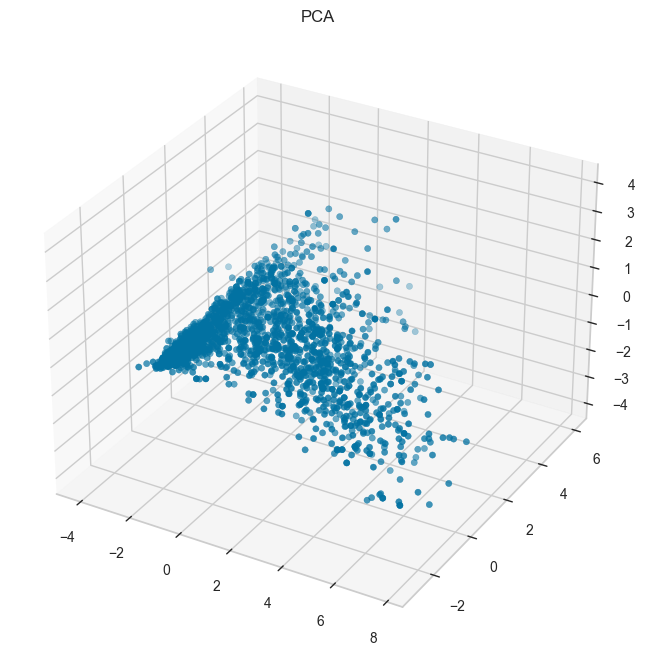

In [69]:
#3D projection of pca_dp
x = pca_dp['feat_1']
y = pca_dp['feat_2']
z = pca_dp['feat_3']

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x,y,z)
ax.set_title("PCA")

## Clustering

**I will be performing clustering via Agglomerative clustering**

Agglomerative clustering is a type of hierarchical clustering algorithm that builds clusters based on the bottom-up approach. It starts by treating each data point as a single cluster and then iteratively merges the closest pairs of clusters into larger clusters until all points have been merged into a single cluster or until a specified number of clusters is reached.

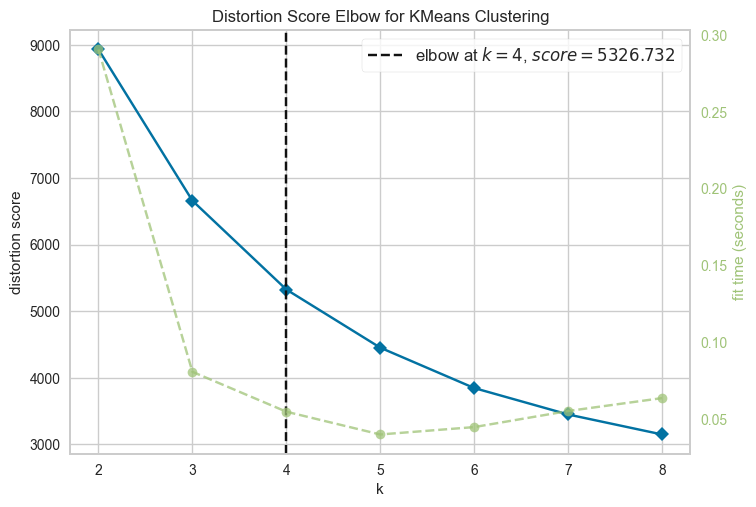

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [70]:
#Using the elbow method to determine the number of clusters to make

elbow = KElbowVisualizer(KMeans(), k=8)
elbow.fit(pca_dp)
elbow.show()

**The eblow method indicates that 4 clusters are the optimal number of clusters for this dataset**

In [71]:
ac = AgglomerativeClustering(n_clusters=4)

#fitting the model
prediction = ac.fit_predict(pca_dp)
pca_dp['Clusters'] = prediction

#also adding the Clusters to the original dataframe to interpret the results
data['Clusters'] = prediction

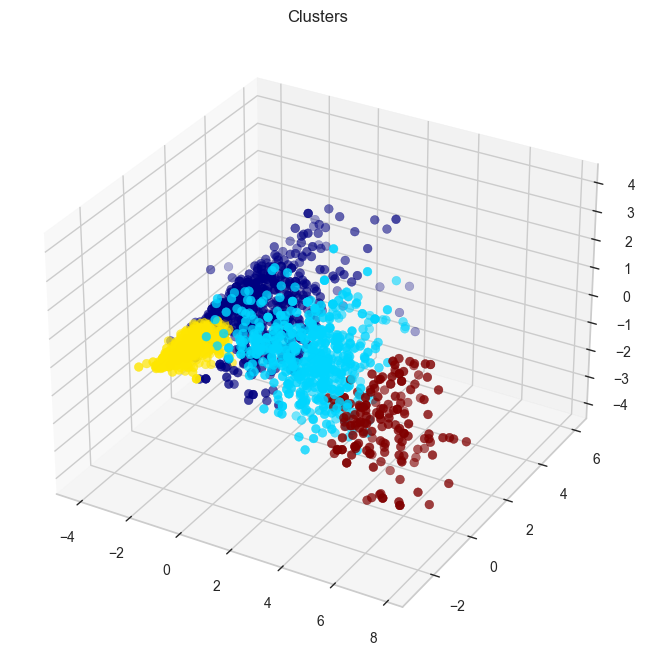

In [72]:
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=pca_dp["Clusters"], cmap='jet')
ax.set_title("Clusters")
plt.show()

## Evaluating the Model

As clustering/segmentation is n unsupervised task there is no clear metric to determine how accurate the model is, or a loss function.

To remedy this we will be using an EDA apporach to interpreting the results.

<AxesSubplot:xlabel='Clusters', ylabel='count'>

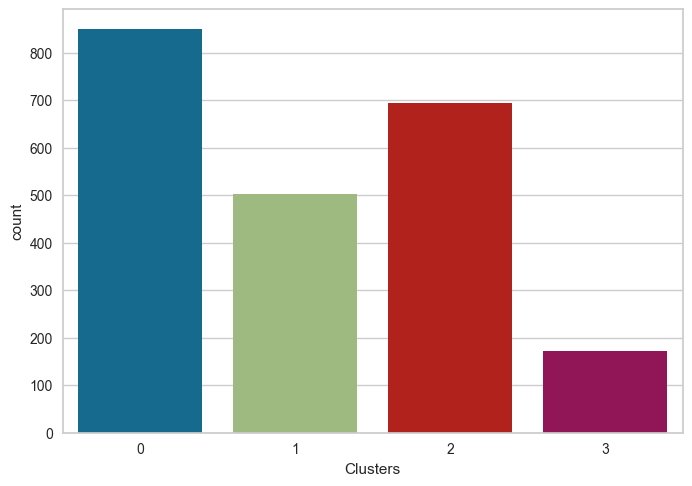

In [73]:
sns.countplot(x=data['Clusters'])

There seems to be a relatively even split in the share of the audience in each cluster, outside of cluster 3 which is the smallest by a fair margin

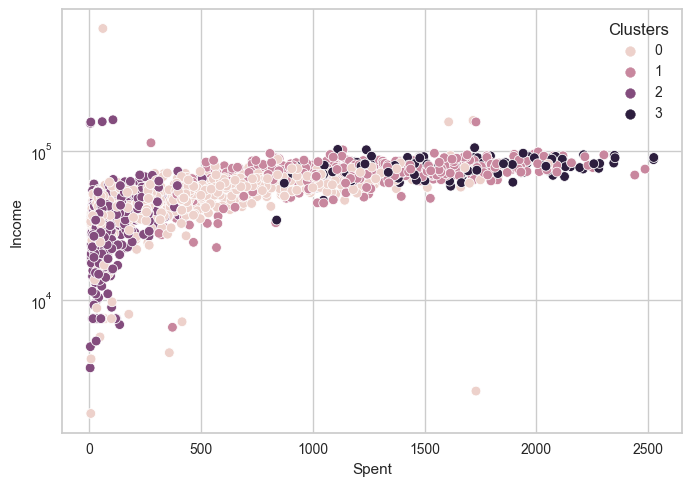

In [74]:
sns.scatterplot(data=data,x=data["Spent"], y=data["Income"],hue=data["Clusters"])
plt.yscale('log')

**Income vs. Spend shows cluster patterns**
- cluster0: mid income, mid to low spend
- cluster1: high to mid income, high to mid spend
- cluster2: mid to low income, low spend
- cluster3: high income, high spend

<AxesSubplot:xlabel='Clusters', ylabel='Spent'>

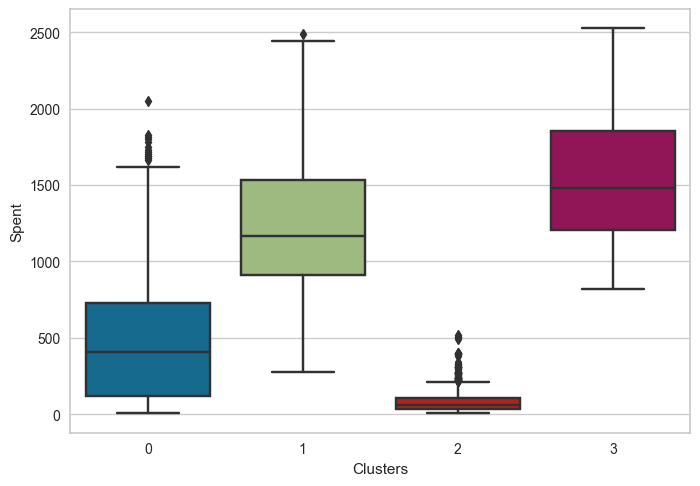

In [75]:
sns.boxplot(x=data['Clusters'], y=data['Spent'])

From the above we can see in a more clear visualisation that cluster 3 and 1 are the highest spending followed by 0 and 2.

<AxesSubplot:xlabel='Clusters', ylabel='NumDealsPurchases'>

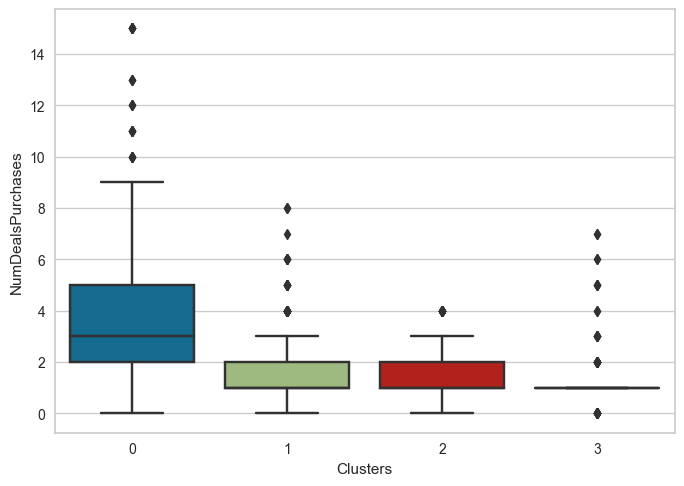

In [76]:
sns.boxplot(x=data['Clusters'], y=data['NumDealsPurchases'])

Despite being the highest spenders, cluster 3 has participated in the least amount of deals. Clusters 0 has puchased the most amount of deals out of all clusters.

<AxesSubplot:xlabel='Clusters', ylabel='NumWebPurchases'>

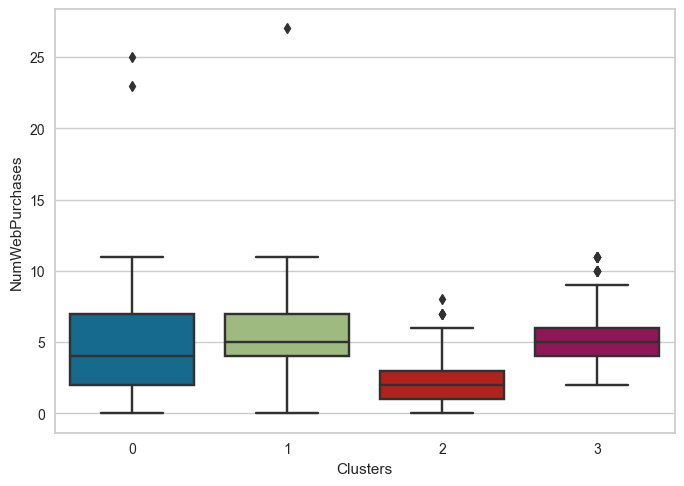

In [77]:
sns.boxplot(x=data['Clusters'], y=data['NumWebPurchases'])

All 4 clusters seem to have similar levels of purchases online, with 0, 1 and 3 averaging around 5, while cluster 2 is around 2.5.

## Profiling

In [78]:
data.columns

Index(['Education', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'Wines',
       'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
       'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response', 'Customer_For',
       'Age', 'Relationship', 'Children', 'Household', 'Parent', 'Spent',
       'Clusters'],
      dtype='object')

In [79]:
personal = ['Education', 'Income', 'Kidhome', 'Teenhome', 'Customer_For', 'Age', 'Relationship', 'Children', 'Household', 'Parent']

In [80]:
data[personal].head(1)

,Education,Income,Kidhome,Teenhome,Customer_For,Age,Relationship,Children,Household,Parent
0,0,58138.0,0,0,971,67,0,0,1,0


### Visualisations of Clusters

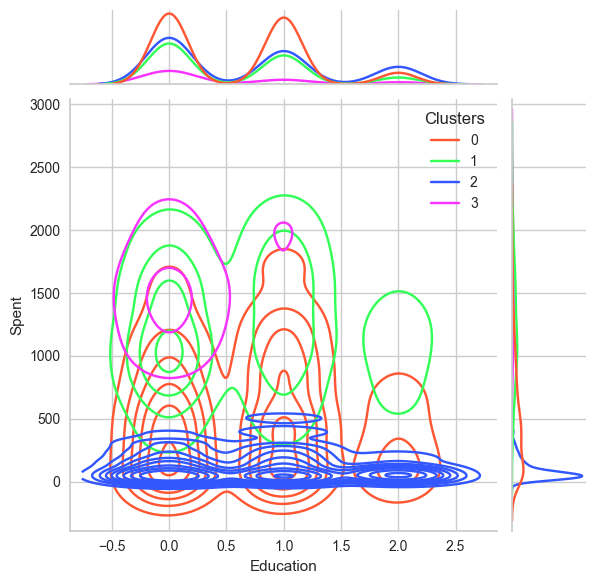

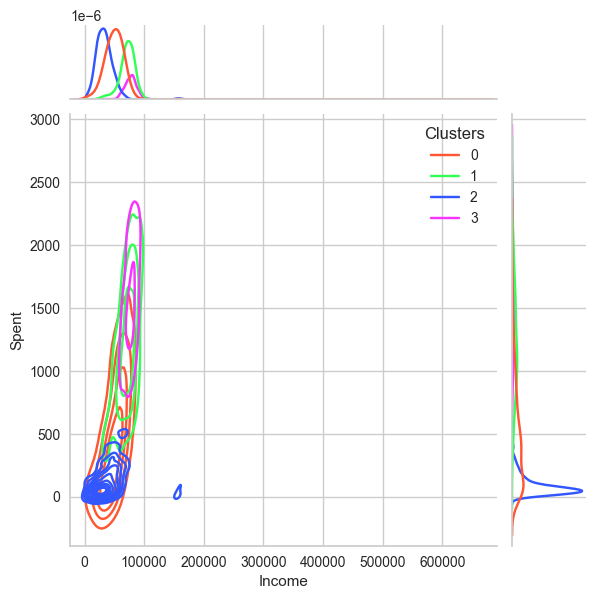

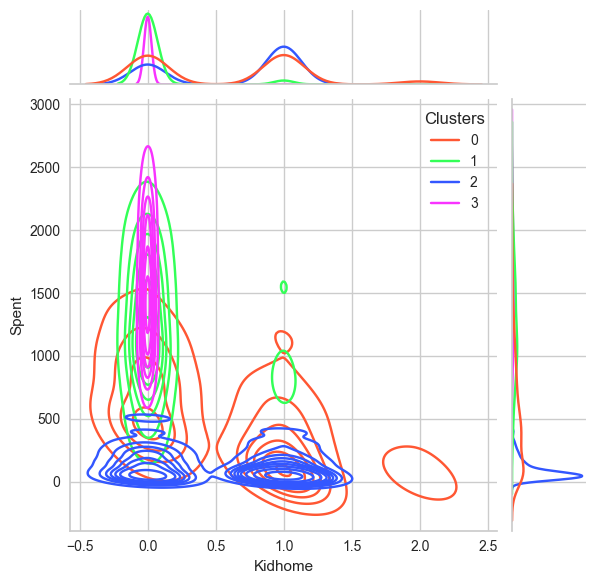

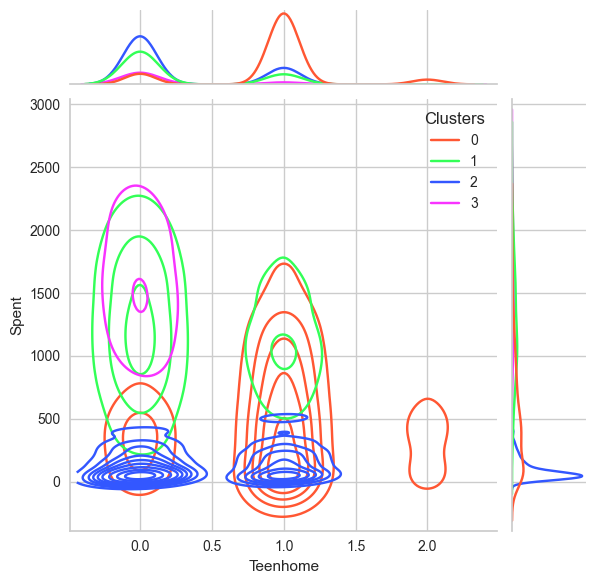

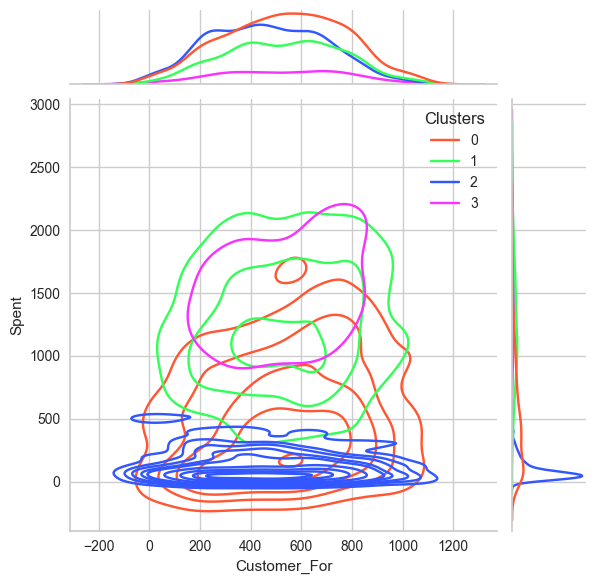

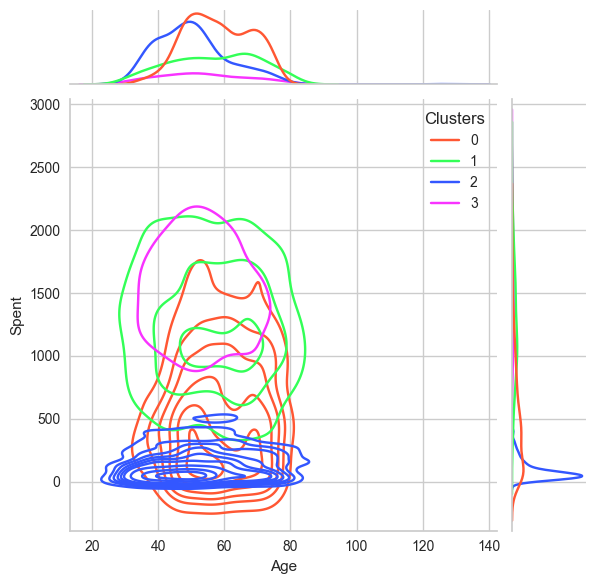

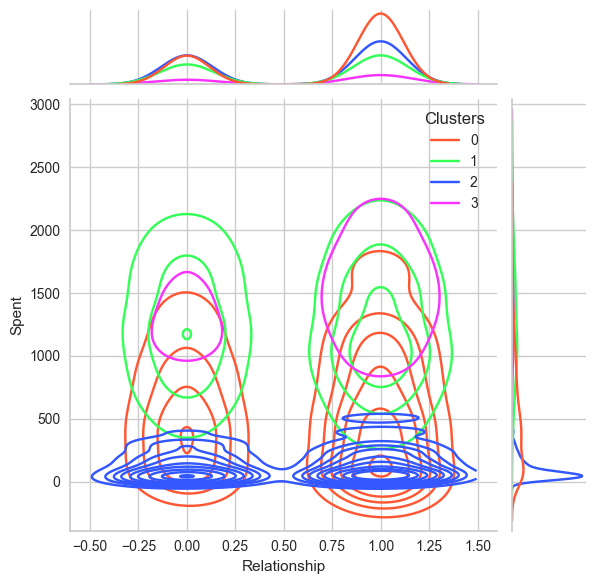

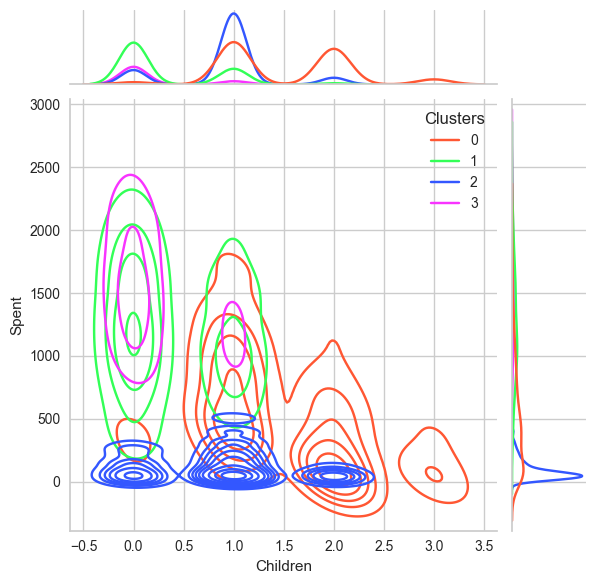

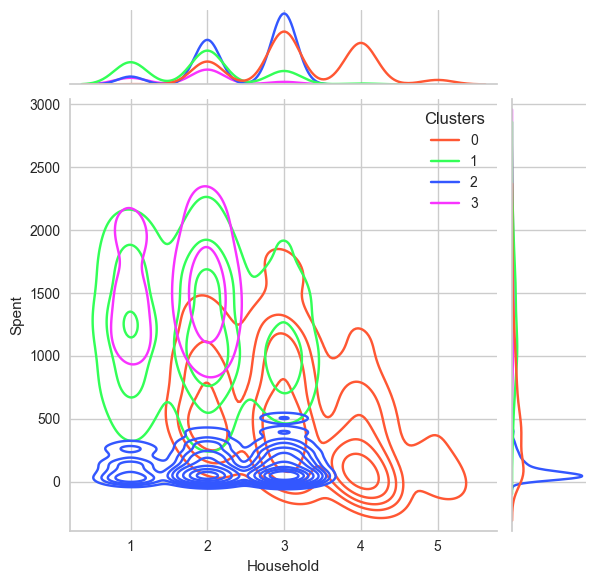

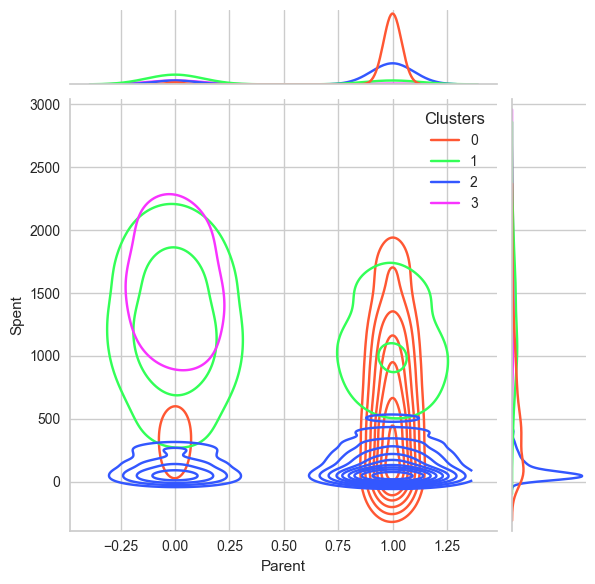

In [81]:
palette = ["#FF5733", "#33FF57", "#3357FF", "#F833FF"]
def profiling(df, columns):
     for i in columns:
         sns.jointplot(data=df, x=i, y='Spent', hue='Clusters', palette=palette, kind='kde')

profiling(data, personal)

### Customer Segments

**Audiences**
- The Family Focused Shoppers (Cluster 0)
- The Affluent Empty Nesters (Cluster 1)
- The Budget-Conscious Families (Cluster 2)
- The High-Earning Professionals (Cluster 3)

**The Family Focused Shoppers**
- <u>Typical Attributes:</u> These customers have a moderate income (median around $50,785), with a notable number of children and teenagers at home. They have a higher tendency to be part of a larger household (median household size of 3).
- <u>Spending Behavior:</u> Their spending is relatively lower (median spent is $407), focusing less on luxuries and more on essentials. This segment might prioritize purchases that offer value for the entire family.
- <u>Demographics and Lifestyle:</u> Education varies, but there is a slight lean towards having at least some college education. They are predominantly in a relationship and likely to be parents, emphasizing family-oriented products and services.

**The Affluent Empty Nesters**
- <u>Typical Attributes:</u> This group enjoys the highest income level among the segments (median around $72,335) and has the least number of children at home, indicating that their children might have grown up and moved out.
- <u>Spending Behavior:</u> They exhibit significant spending power (median spent is $1,169), with substantial purchases in wines, luxury goods, and possibly travel and leisure activities, reflecting a lifestyle of affluence and leisure.
- <u>Demographics and Lifestyle:</u> Most have achieved higher education and are in a relationship. The absence of children at home suggests a focus on quality, premium products, and services for personal enjoyment or dual-income no-kid (DINK) lifestyle experiences.

**The Budget-Concious Families**
- <u>Typical Attributes:</u> With the lowest median income ($32,173), these customers likely have tight budgets. They have a mix of younger children and teenagers at home and a median household size of 3.
- <u>Spending Behavior:</u> Their spending is the lowest among all segments (median spent is $60), which could indicate a focus on essential goods and services, likely looking for deals and discounts.
- <u>Demographics and Lifestyle:</u> Education levels might vary, with a slight preference for some college education. This segment is likely to benefit from cost-effective solutions, discounts, and value-oriented marketing.

**The High-Earning Professionals**
- <u>Typical Attributes:</u> This segment shows a very high income (median around $78,618) with few to no children at home, suggesting they might be professionals or established individuals with significant disposable income.
- <u>Spending Behavior:</u> Their spending is the highest (median spent is $1,479), likely indulging in high-end products, wines, and gourmet foods, reflecting a penchant for luxury and quality.
- <u>Demographics and Lifestyle:</u> They have a diverse educational background, with a balance between single and in-relationship statuses. Marketing to this segment would do well to emphasize quality, exclusivity, and premium experiences.